In [1]:
import attack_kernelbased
import attack_fgsm
import attack_df
import attack_jsma
import attack_gen
import dataloader
import spatial

import torch
import torch.nn as nn
import numpy as np
import time
import onlinehd
import DNNmodels
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tqdm
import copy

In [2]:
X_train, X_test, y_train, y_test = dataloader.load(dataset_name='face_full')

classes = y_train.unique().size(0)
features = X_train.size(1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([522441, 608]),
 torch.Size([2494, 608]),
 torch.Size([522441]),
 torch.Size([2494]))

In [3]:
X_test = X_test[:1000]
y_test = y_test[:1000]

100%|██████████| 30/30 [1:34:15<00:00, 188.52s/it]


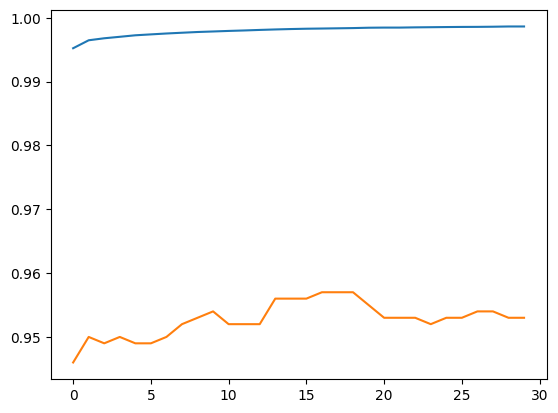

0.9986218810081482 0.9570000171661377


In [4]:
D = 4000
acc_history, test_acc_history = [], []
model = onlinehd.OnlineHD(classes, features, dim=D)
best_model = None
for _ in tqdm.tqdm(range(30)):
  model = model.fit(X_train, y_train, bootstrap=1.0, lr=0.035, epochs=1, one_pass_fit=False)
  
  yhat_train = model(X_train)
  yhat_test = model(X_test)

  acc = (y_train == yhat_train).float().mean().item()
  acc_test = (y_test == yhat_test).float().mean().item()

  if best_model is None or max(test_acc_history) < acc_test:
    best_model = copy.deepcopy(model)

  acc_history.append(acc)
  test_acc_history.append(acc_test)
model = best_model

plt.plot(acc_history, label='train')
plt.plot(test_acc_history, label='test')
plt.show()
print(max(acc_history), max(test_acc_history))

In [5]:
with open('./onlinehd_facefull.pickle', 'bw') as f:
    pickle.dump(model, f)

In [6]:
with open('./onlinehd_facefull.pickle', 'br') as f:
    model = pickle.load(f)

In [7]:
model_dnn = DNNmodels.NeuralNetwork(num_classes=classes, flatten_layer=False, input_dim=features)
model_dnn.load_state_dict(torch.load('./model_dnn_facefull.pt'))
model_dnn.eval()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=608, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)

## Kernel based attack

In [8]:
# with complex encoding (FHRR)
for e in np.linspace(0.01, 0.1, 10):#[0.01, 0.03, 0.07, 0.1]:
    st = time.time()
    X_test_noised = attack_kernelbased.genAdversarialNoise(model, X_test, y_test, e)
    print(time.time() - st)
    
    yhat_test = model(X_test_noised)
    yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
    distance = (X_test_noised - X_test).norm(dim=-1).mean().item()

    print(e, distance, onlinehd_attacked_acc, dnn_attacked_acc)

100%|██████████| 1000/1000 [00:32<00:00, 30.95it/s]


33.02679681777954
0.01 0.009569999761879444 0.9240000247955322 0.9459999799728394


100%|██████████| 1000/1000 [00:33<00:00, 30.14it/s]


34.002418994903564
0.020000000000000004 0.019140001386404037 0.8960000276565552 0.9279999732971191


100%|██████████| 1000/1000 [00:33<00:00, 29.93it/s]


34.10434913635254
0.030000000000000006 0.028710002079606056 0.8579999804496765 0.9089999794960022


100%|██████████| 1000/1000 [00:32<00:00, 30.51it/s]


33.46955490112305
0.04000000000000001 0.03827999532222748 0.8029999732971191 0.8830000162124634


100%|██████████| 1000/1000 [00:32<00:00, 30.82it/s]


33.159523010253906
0.05000000000000001 0.04785000532865524 0.7440000176429749 0.8450000286102295


100%|██████████| 1000/1000 [00:32<00:00, 30.85it/s]


33.11131715774536
0.06000000000000001 0.05742000415921211 0.6660000085830688 0.8190000057220459


100%|██████████| 1000/1000 [00:32<00:00, 30.66it/s]


33.32753586769104
0.07 0.06699000298976898 0.5839999914169312 0.7739999890327454


100%|██████████| 1000/1000 [00:32<00:00, 30.55it/s]


33.46245503425598
0.08 0.07655999809503555 0.49399998784065247 0.7300000190734863


100%|██████████| 1000/1000 [00:32<00:00, 30.48it/s]


33.51369094848633
0.09000000000000001 0.08613001555204391 0.41600000858306885 0.6700000166893005


100%|██████████| 1000/1000 [00:32<00:00, 30.82it/s]


33.16055607795715
0.1 0.09570001065731049 0.3310000002384186 0.6069999933242798


## FGSM

### Normlized

In [9]:
epsilons = np.linspace(0.01, 0.1, 10) # torch.Tensor([0.01, 0.03, 0.07, 0.1])
verbose = False
#criterion = nn.CosineEmbeddingLoss()
criterion = lambda output, model, label: (spatial.cos_cdist(output, model) - label).mean()
#criterion = lambda output, model, label: output.mean()
N_VAL_SAMPLES = X_test.data.shape[0]

attack_samples, acc_results = attack_fgsm.attack(
    model, X_train, X_test, y_test, epsilons, classes, criterion, N_VAL_SAMPLES, 'cpu', 
    input_dim=features, model_type='dnn')

100%|██████████| 1000/1000 [00:04<00:00, 232.61it/s]



FGSM Attack with epsilon = 0.01000 | Elapsed time: 4.302399958000024 seconds.
Accuracy: Before the attack -> 95.70%	|	After the attack -> 95.80%
mean of norm=0.00999999325722456


100%|██████████| 1000/1000 [00:04<00:00, 239.16it/s]



FGSM Attack with epsilon = 0.02000 | Elapsed time: 4.1906878749996395 seconds.
Accuracy: Before the attack -> 95.70%	|	After the attack -> 95.60%
mean of norm=0.02000000700354576


100%|██████████| 1000/1000 [00:04<00:00, 240.79it/s]



FGSM Attack with epsilon = 0.03000 | Elapsed time: 4.17509549999977 seconds.
Accuracy: Before the attack -> 95.70%	|	After the attack -> 95.60%
mean of norm=0.030000001192092896


100%|██████████| 1000/1000 [00:04<00:00, 238.44it/s]



FGSM Attack with epsilon = 0.04000 | Elapsed time: 4.2012568339996506 seconds.
Accuracy: Before the attack -> 95.70%	|	After the attack -> 95.60%
mean of norm=0.04000001400709152


100%|██████████| 1000/1000 [00:04<00:00, 209.80it/s]



FGSM Attack with epsilon = 0.05000 | Elapsed time: 4.7759219170002325 seconds.
Accuracy: Before the attack -> 95.70%	|	After the attack -> 95.50%
mean of norm=0.05000000447034836


100%|██████████| 1000/1000 [00:04<00:00, 212.83it/s]



FGSM Attack with epsilon = 0.06000 | Elapsed time: 4.705870999999206 seconds.
Accuracy: Before the attack -> 95.70%	|	After the attack -> 95.20%
mean of norm=0.06000000238418579


100%|██████████| 1000/1000 [00:04<00:00, 235.64it/s]



FGSM Attack with epsilon = 0.07000 | Elapsed time: 4.2531150830000115 seconds.
Accuracy: Before the attack -> 95.70%	|	After the attack -> 95.20%
mean of norm=0.06999999284744263


100%|██████████| 1000/1000 [00:04<00:00, 238.09it/s]



FGSM Attack with epsilon = 0.08000 | Elapsed time: 4.209361333000743 seconds.
Accuracy: Before the attack -> 95.70%	|	After the attack -> 95.00%
mean of norm=0.08000002801418304


100%|██████████| 1000/1000 [00:04<00:00, 235.52it/s]



FGSM Attack with epsilon = 0.09000 | Elapsed time: 4.255307540999638 seconds.
Accuracy: Before the attack -> 95.70%	|	After the attack -> 94.80%
mean of norm=0.09000003337860107


100%|██████████| 1000/1000 [00:04<00:00, 237.49it/s]


FGSM Attack with epsilon = 0.10000 | Elapsed time: 4.22315987499951 seconds.
Accuracy: Before the attack -> 95.70%	|	After the attack -> 94.70%
mean of norm=0.10000003129243851


In [10]:
for e, X_test_noised in zip(epsilons, attack_samples):
    yhat_test = model(X_test_noised.reshape(-1, features))
    yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

    print(e, distance, onlinehd_attacked_acc, dnn_attacked_acc)

0.01 0.00999999325722456 0.9580000042915344 0.9580000042915344
0.020000000000000004 0.02000000700354576 0.9559999704360962 0.9570000171661377
0.030000000000000006 0.030000001192092896 0.9559999704360962 0.9539999961853027
0.04000000000000001 0.04000001400709152 0.9559999704360962 0.9549999833106995
0.05000000000000001 0.05000000447034836 0.9549999833106995 0.9520000219345093
0.06000000000000001 0.06000000238418579 0.9520000219345093 0.9509999752044678
0.07 0.06999999284744263 0.9520000219345093 0.9480000138282776
0.08 0.08000002801418304 0.949999988079071 0.9470000267028809
0.09000000000000001 0.09000003337860107 0.9480000138282776 0.9430000185966492
0.1 0.10000003129243851 0.9470000267028809 0.9409999847412109


## Deep Fool

In [12]:
for max_update in np.linspace(0.01, 0.2, 20):
    X_te_cln = X_test.clone().reshape(-1, 1, features)
    Y_te_cln = y_test.clone()

    x_test_adv = torch.zeros(X_te_cln.shape)
    x_test_pert = torch.zeros(X_te_cln.shape[0], features)

    st = time.time()
    for i in tqdm.tqdm(range(X_test.shape[0])):
        x_test_adv[i], x_test_pert[i] = attack_df.deepfool(X_te_cln[i], model, epsilon=max_update, num_classes=classes, input_dim=features, model_type='dnn')
    print(time.time() - st)
    
    X_test_noised = x_test_adv.reshape(-1, features)

    yhat_test = model(X_test_noised.reshape(-1, features))
    yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

    print(max_update, distance, onlinehd_attacked_acc, dnn_attacked_acc)

100%|██████████| 1000/1000 [00:36<00:00, 27.25it/s]


36.695034980773926
0.01 0.009594546630978584 0.9359999895095825 0.9520000219345093


100%|██████████| 1000/1000 [00:35<00:00, 27.83it/s]


35.939242124557495
0.02 0.01918909326195717 0.9179999828338623 0.9399999976158142


100%|██████████| 1000/1000 [00:33<00:00, 29.71it/s]


33.662731885910034
0.03 0.028783638030290604 0.8899999856948853 0.925000011920929


100%|██████████| 1000/1000 [00:31<00:00, 31.49it/s]


31.757105112075806
0.04 0.03837818652391434 0.8420000076293945 0.906000018119812


100%|██████████| 1000/1000 [00:33<00:00, 29.94it/s]


33.4077570438385
0.05 0.04797273874282837 0.7860000133514404 0.871999979019165


100%|██████████| 1000/1000 [00:29<00:00, 33.64it/s]


29.733612060546875
0.060000000000000005 0.05756727606058121 0.7089999914169312 0.843999981880188


100%|██████████| 1000/1000 [00:25<00:00, 38.89it/s]


25.71643590927124
0.06999999999999999 0.06716182082891464 0.6269999742507935 0.8019999861717224


100%|██████████| 1000/1000 [00:22<00:00, 44.16it/s]


22.648046255111694
0.08 0.07675636559724808 0.5370000004768372 0.7599999904632568


100%|██████████| 1000/1000 [00:20<00:00, 49.85it/s]


20.063469171524048
0.09 0.0863509252667427 0.45899999141693115 0.6990000009536743


100%|██████████| 1000/1000 [00:17<00:00, 58.69it/s]


17.041712760925293
0.09999999999999999 0.09594547748565674 0.37400001287460327 0.6349999904632568


100%|██████████| 1000/1000 [00:14<00:00, 67.61it/s]


14.792936325073242
0.11 0.10554000735282898 0.30000001192092896 0.5630000233650208


100%|██████████| 1000/1000 [00:12<00:00, 81.15it/s]


12.325014114379883
0.12 0.11513456702232361 0.23100000619888306 0.5070000290870667


100%|██████████| 1000/1000 [00:10<00:00, 91.38it/s]


10.945966005325317
0.13 0.12472909688949585 0.18799999356269836 0.4390000104904175


100%|██████████| 1000/1000 [00:09<00:00, 104.89it/s]


9.536601781845093
0.14 0.13432364165782928 0.14900000393390656 0.38100001215934753


100%|██████████| 1000/1000 [00:08<00:00, 113.69it/s]


8.798383951187134
0.15000000000000002 0.1439182013273239 0.12399999797344208 0.31200000643730164


100%|██████████| 1000/1000 [00:07<00:00, 125.88it/s]


7.94697380065918
0.16 0.15351273119449615 0.10199999809265137 0.25999999046325684


100%|██████████| 1000/1000 [00:07<00:00, 139.05it/s]


7.193468809127808
0.17 0.16310729086399078 0.08100000023841858 0.22100000083446503


100%|██████████| 1000/1000 [00:07<00:00, 141.37it/s]


7.075359106063843
0.18000000000000002 0.1727018803358078 0.07500000298023224 0.1720000058412552


100%|██████████| 1000/1000 [00:07<00:00, 142.39it/s]


7.0253801345825195
0.19 0.18229639530181885 0.07100000232458115 0.1589999943971634


100%|██████████| 1000/1000 [00:07<00:00, 125.90it/s]


7.945570707321167
0.2 0.19189095497131348 0.07000000029802322 0.13099999725818634


In [13]:
X_te_cln = X_test.clone().reshape(-1, 1, features)
Y_te_cln = y_test.clone()

x_test_adv = torch.zeros(X_te_cln.shape)
x_test_pert = torch.zeros(X_te_cln.shape[0], features)

for i in tqdm.tqdm(range(X_test.shape[0])):
    x_test_adv[i], x_test_pert[i] = attack_df.deepfool(X_te_cln[i], model, epsilon=None, num_classes=classes, input_dim=features, model_type='dnn')

X_test_noised = x_test_adv.reshape(-1, features)

yhat_test = model(X_test_noised.reshape(-1, features))
yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

print(None, distance, onlinehd_attacked_acc, dnn_attacked_acc)

100%|██████████| 1000/1000 [00:06<00:00, 144.32it/s]


None 0.2349575310945511 0.0689999982714653 0.10100000351667404


## Genetic Attack

In [14]:
alpha_lis = np.linspace(0.0001, 0.0015, 20) #[0.01, 0.03, 0.07, 0.1]
delta = 0.5
nData = len(alpha_lis)
model_accuracy_GA = np.zeros(nData)

x_test_samp = X_test.cpu()
y_test_samp = y_test.cpu()

for n in range(nData):
    alpha = alpha_lis[n]
    print(f"Alpha : {alpha}")

    st = time.time()
    x_test_GA, _ = attack_gen.make_GA(model, delta, alpha, x_test_samp, y_test_samp)
    print(time.time() - st)
    
    X_test_noised = x_test_GA.reshape(-1, features)

    yhat_test = model(X_test_noised.reshape(-1, features))
    yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

    print(alpha, distance, onlinehd_attacked_acc, dnn_attacked_acc)

#model_accuracy_GA

Alpha : 0.0001


100%|██████████| 1000/1000 [1:35:21<00:00,  5.72s/it]


5721.4837419986725
0.0001 0.025606170296669006 0.9359999895095825 0.9589999914169312
Alpha : 0.0001736842105263158


100%|██████████| 1000/1000 [1:31:29<00:00,  5.49s/it]


5489.93183016777
0.0001736842105263158 0.044321175664663315 0.9179999828338623 0.9589999914169312
Alpha : 0.0002473684210526316


100%|██████████| 1000/1000 [1:37:14<00:00,  5.83s/it]


5834.78767490387
0.0002473684210526316 0.06261362135410309 0.9010000228881836 0.9589999914169312
Alpha : 0.00032105263157894735


100%|██████████| 1000/1000 [1:35:32<00:00,  5.73s/it]


5732.118710041046
0.00032105263157894735 0.0800241082906723 0.8870000243186951 0.9599999785423279
Alpha : 0.00039473684210526315


100%|██████████| 1000/1000 [1:28:46<00:00,  5.33s/it]


5326.650287151337
0.00039473684210526315 0.09837167710065842 0.8640000224113464 0.9599999785423279
Alpha : 0.00046842105263157895


100%|██████████| 1000/1000 [1:27:37<00:00,  5.26s/it]


5257.951081037521
0.00046842105263157895 0.11420883238315582 0.8299999833106995 0.9599999785423279
Alpha : 0.0005421052631578948


100%|██████████| 1000/1000 [1:26:16<00:00,  5.18s/it]


5176.536889791489
0.0005421052631578948 0.13070160150527954 0.8050000071525574 0.9599999785423279
Alpha : 0.0006157894736842106


100%|██████████| 1000/1000 [1:22:29<00:00,  4.95s/it]


4949.919363021851
0.0006157894736842106 0.14458270370960236 0.7749999761581421 0.9599999785423279
Alpha : 0.0006894736842105264


100%|██████████| 1000/1000 [1:15:43<00:00,  4.54s/it]


4543.762489080429
0.0006894736842105264 0.15765897929668427 0.7490000128746033 0.9599999785423279
Alpha : 0.0007631578947368421


100%|██████████| 1000/1000 [1:01:08<00:00,  3.67s/it]


3668.1602816581726
0.0007631578947368421 0.1684739887714386 0.7080000042915344 0.9599999785423279
Alpha : 0.000836842105263158


100%|██████████| 1000/1000 [53:29<00:00,  3.21s/it]


3210.02383518219
0.000836842105263158 0.17552544176578522 0.6869999766349792 0.9599999785423279
Alpha : 0.0009105263157894737


100%|██████████| 1000/1000 [49:32<00:00,  2.97s/it]


2973.0223429203033
0.0009105263157894737 0.17999234795570374 0.6769999861717224 0.9589999914169312
Alpha : 0.0009842105263157895


100%|██████████| 1000/1000 [46:44<00:00,  2.80s/it]


2804.7680621147156
0.0009842105263157895 0.1819942444562912 0.6669999957084656 0.9599999785423279
Alpha : 0.0010578947368421053


100%|██████████| 1000/1000 [43:38<00:00,  2.62s/it]


2618.4909896850586
0.0010578947368421053 0.18309906125068665 0.6589999794960022 0.9599999785423279
Alpha : 0.0011315789473684212


100%|██████████| 1000/1000 [40:50<00:00,  2.45s/it]


2450.335216283798
0.0011315789473684212 0.18395759165287018 0.652999997138977 0.9599999785423279
Alpha : 0.0012052631578947368


100%|██████████| 1000/1000 [40:56<00:00,  2.46s/it]


2456.3349239826202
0.0012052631578947368 0.1845701038837433 0.6570000052452087 0.9599999785423279
Alpha : 0.0012789473684210527


100%|██████████| 1000/1000 [1:15:04<00:00,  4.50s/it]  


4504.424549818039
0.0012789473684210527 0.18485420942306519 0.6549999713897705 0.9599999785423279
Alpha : 0.0013526315789473685


100%|██████████| 1000/1000 [38:34<00:00,  2.31s/it]


2314.5035099983215
0.0013526315789473685 0.18512356281280518 0.6520000100135803 0.9599999785423279
Alpha : 0.0014263157894736842


100%|██████████| 1000/1000 [33:38<00:00,  2.02s/it]


2018.9128341674805
0.0014263157894736842 0.18556258082389832 0.6539999842643738 0.9599999785423279
Alpha : 0.0015


100%|██████████| 1000/1000 [33:46<00:00,  2.03s/it]


2026.9855298995972
0.0015 0.18627843260765076 0.6539999842643738 0.9589999914169312
